### Kaggle competition to predict whether a given tweet is about a real disaster or not.  If yes, predict a 1. If not, predict a 0.

Competition - https://www.kaggle.com/competitions/nlp-getting-started/data?select=test.csv

### General approach-
#### 1. Text Cleaning & Processing 
* Cleaning
* Normalization
* Tokenization
* Stop word removal
* POS - parts of speech tagging (to do)
* NER - named entity recognition (to do)
* Stemming & Lemmatization

#### 2. Feature Extraction
* TF-IDF (term frequency–inverse document frequency)
* Bag of Words (to do)
* Word embeddings

#### 3. Modeling
* Logistic regression
* Naive Bayes


In [290]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

### <font color = 'green'> Importing libraries

In [7]:
# Imports
import nltk

import regex as re
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns


# For Text pre-processing
from word2number import w2n
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# from nltk import word_tokenize, pos_tag, pos_tag_sents

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


# Visualize
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Sklearn
# Performance metrics
from sklearn.metrics import f1_score 
from sklearn.metrics import accuracy_score
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier 
# Model
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



### <font color = 'green'> Loading train dataset to explore

In [324]:
raw_train_df = pd.read_csv('train.csv')
raw_train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [325]:
raw_train_df.duplicated().sum()

0

In [326]:
raw_train_df.shape

(7613, 5)

In [16]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [11]:
raw_train_df.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

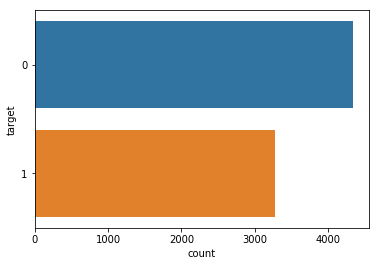

In [323]:
## Check distribution of disaster & non-disaster based tweets 
sns.countplot(y=df.target)

### <font color = 'green'> Clean & preprocess the dataset

In [19]:
## Function to remove numeric values
def check_num(x):
    """
    Remove numbers from list
    :param x:list of words
    :return: list of words without any numbers

    E.g: ETL.check_num(['five','four','day','sun']) will return ['day','sun']
    """
    word_list = []
    remove_list = []
    for i in x:
        try:
            w2n.word_to_num(i)
            remove_list.append(i)
        except ValueError:
            word_list.append(i)
    return "".join(word_list)

## Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [15]:
## Function to clean the textual data
def text_preprocess(sentence):
    # Convert text to lowercase
    sentence=str(sentence)
    sentence = sentence.lower()
    
    # Remove special char, numbers/digits, URLs
    sentence = re.sub('\W+',' ', sentence)
    clean_sentence = re.sub('http://\S+|https://\S+', ' ', sentence)
    
    # A tokenizer that splits a string using a regular expression, 
    # which matches either the tokens or the separators between tokens.
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(clean_sentence) 

    # Remove stopwords
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

    # Stemming the words (eg. Studies => Studi)
    stemmer = PorterStemmer()
    stem_words=[stemmer.stem(w) for w in filtered_words]

#     # Lemmatize (eg. Studies => Study)
#     lemmatizer = WordNetLemmatizer()
#     lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
            
    return " ".join(stem_words)

In [16]:
raw_train_df = pd.read_csv('train.csv')

In [17]:
## Apply preprocessing
raw_train_df['clean_text'] = raw_train_df['text'].apply(text_preprocess)

In [12]:
from urllib.parse import urlparse
#https://stackoverflow.com/a/52455972
def is_url(url):
  try:
    result = urlparse(url)
    return all([result.scheme, result.netloc])
  except ValueError:
    return False

In [20]:
## Remove URLs, Emojis, numbers from tweet
raw_train_df['clean_text'] = [' '.join(y for y in x.split() if not is_url(y)) for x in raw_train_df['text']]
raw_train_df['clean_text'] = raw_train_df['clean_text'].apply(lambda x: remove_emoji(x))
raw_train_df['clean_text'] = raw_train_df['clean_text'].str.replace('\d+', '')
raw_train_df['clean_text'] = raw_train_df['clean_text'].str.replace("#",'')
raw_train_df['clean_text'] = raw_train_df['clean_text'].str.replace("@",'')
raw_train_df['clean_text'] = raw_train_df['clean_text'].str.replace(".",'')


In [23]:
raw_train_df['text'][100]

'.@NorwayMFA #Bahrain police had previously died in a road accident they were not killed by explosion https://t.co/gFJfgTodad'

In [24]:
raw_train_df['clean_text'][100]

'NorwayMFA Bahrain police had previously died in a road accident they were not killed by explosion'

In [384]:
raw_train_df.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [8]:
## List the top frequest keywords in show overview
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [44]:
## Get top 25 Frequent keywords
wordcount_list = raw_train_df['clean_text'].tolist()
freq_keywords = get_top_n_words(wordcount_list,25)

df_wordcounts = pd.DataFrame(freq_keywords, columns=['words','freq'])
df_wordcounts

,words,freq
0,like,348
1,amp,344
2,fire,254
3,get,229
4,new,226
5,via,220
6,news,202
7,people,200
8,one,196
9,video,165


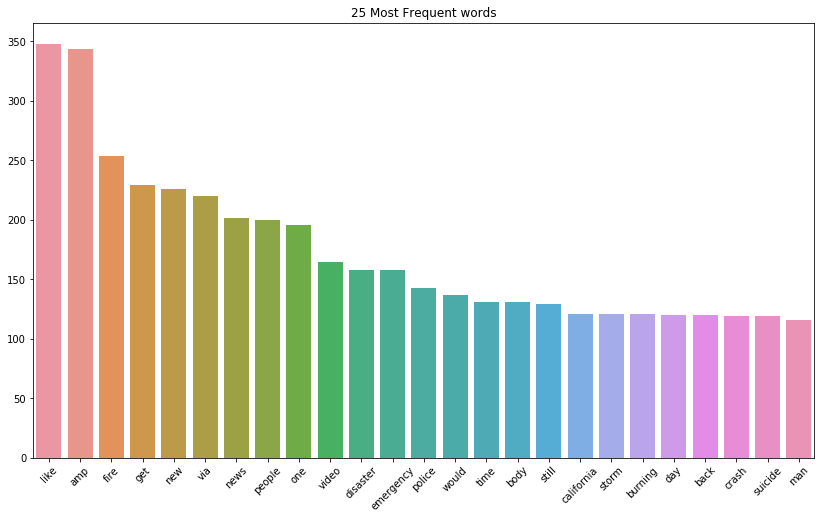

In [45]:
import matplotlib.pyplot as plt
# create bar plot of top 20 words
fig, ax = plt.subplots(figsize = (14,8))
_ = sns.barplot(data = df_wordcounts, x = 'words', y = 'freq', ax = ax)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation = 45)
ax.set_title("25 Most Frequent words")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show(fig)

In [137]:
## Wordclouds
disaster_tweets = raw_train_df[raw_train_df['target']==1]['clean_text']
non_disaster_tweets = raw_train_df[raw_train_df['target']==0]['clean_text']

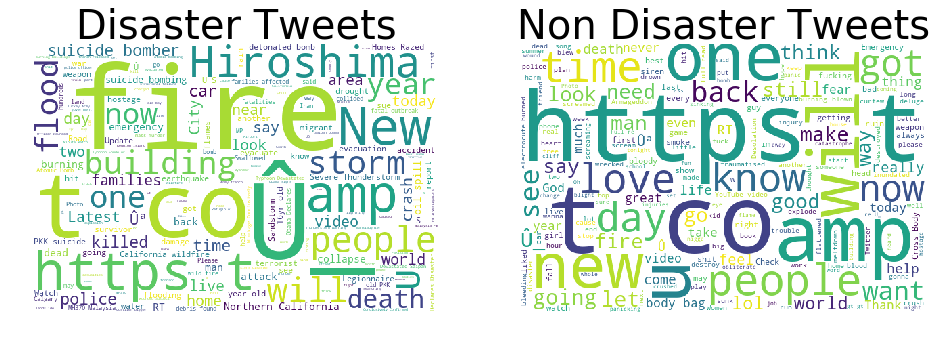

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);

### <font color = 'green'> Text Vectorization using TFIDF 

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=500)

In [26]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(raw_train_df['clean_text'],
                                              raw_train_df['target'],
                                              test_size=0.2, random_state=9)

In [27]:
# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

### <font color = 'green'>Logistic Regression

In [28]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
# Fit the model
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression())

In [29]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [30]:
y_pred

array([1, 0, 1, ..., 1, 0, 0])

In [31]:
# evaluate performance
print("Log regression Accuracy Score: \n ",round(f1_score(yval, y_pred, average="micro")*100,2))

Log regression Accuracy Score: 
  77.68


In [395]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
# new = np.asarray(y_test)
confusion_matrix(y_pred,yval)

array([[738, 198],
       [142, 445]])

In [396]:
print(classification_report(y_pred,yval))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       936
           1       0.69      0.76      0.72       587

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



### <font color = 'green'> Testing MultinomialNB for practice

In [312]:
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score


In [313]:
### <font color = 'green'> Text Vectorization using TFIDF 
count_vectorizer = CountVectorizer()
train_vectors_count = count_vectorizer.fit_transform(raw_train_df['clean_text'])
# test_vectors_count = count_vectorizer.transform(test["text"])

In [314]:
# Fitting a simple Logistic Regression on Counts
CLR = LogisticRegression(C=2)
scores = cross_val_score(CLR, train_vectors_count, raw_train_df["target"], cv=6, scoring="f1")
scores

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.62038074, 0.53550864, 0.59832246, 0.51143451, 0.6273353 ,
       0.72709924])

In [315]:
# Fitting a simple Naive Bayes
NB_Vec = MultinomialNB()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(NB_Vec, train_vectors_count, raw_train_df["target"], cv=cv, scoring="f1")
scores

array([0.76219985, 0.76131045, 0.73902634, 0.75373721, 0.76725522,
       0.75489428, 0.74213836, 0.7510008 , 0.76910828, 0.76182965,
       0.7517843 , 0.74822415, 0.77078477, 0.76107595, 0.76400947])

In [316]:
NB_Vec.fit(train_vectors_count, raw_train_df["target"])


MultinomialNB()

In [317]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline

pipe = Pipeline([('Vectors', CountVectorizer(stop_words='english')),('tfidf', TfidfTransformer()),
     ('NB', MultinomialNB())])
pipe.fit(raw_train_df.clean_text.values, raw_train_df["target"].values)

Pipeline(steps=[('Vectors', CountVectorizer(stop_words='english')),
                ('tfidf', TfidfTransformer()), ('NB', MultinomialNB())])

In [318]:
raw_test_df['clean_text'][5]

'shake earthquak'

In [319]:
predicted = pipe.predict([raw_test_df['clean_text'][5]])

if predicted == 1:
    print("The tweet is Disaster Tweet")
else:
    print("The tweet is Non Disaster Tweet")

The tweet is Disaster Tweet


### <font color = 'green'> Load test dataset

In [398]:
raw_test_df = pd.read_csv('test.csv')
raw_test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [399]:
# Clean text, check & remove numbers
raw_test_df['clean_text'] = raw_test_df['text'].apply(text_preprocess)

In [400]:
## Remove numbers, URLs & Emojis from tweet
raw_test_df['clean_text'] = raw_test_df['clean_text'].str.replace('\d+', '')
raw_test_df['clean_text'] = raw_test_df['clean_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
raw_test_df['clean_text'] = raw_test_df['clean_text'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])
raw_test_df['clean_text'] = raw_test_df['clean_text'].str.replace("#",'')
raw_test_df['clean_text'] = raw_test_df['clean_text'].str.replace("@",'')
raw_test_df['clean_text'] = raw_test_df['clean_text'].apply(lambda x: remove_emoji(x))

In [401]:
raw_test_df['text'][1000]

'A demolished Palestinian village comes back to life http://t.co/Jsf5OFB3m6 via @wagingnv http://t.co/Hskd5MUosM'

In [402]:
raw_test_df['clean_text'][1000]

'demolish palestinian villag come back life http jsfofbm via wagingnv http hskdmuosm'

In [284]:
raw_test_df['clean_text'][5]

'shake earthquak'

In [403]:
raw_test_df.head()

,id,keyword,location,text,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [404]:
test_dataset_val = raw_test_df['clean_text']

In [405]:
test_dataset_val_tfidf2 = tfidf_vectorizer.transform(test_dataset_val)
test_dataset_val_tfidf2

<3263x500 sparse matrix of type '<class 'numpy.float64'>'
	with 14538 stored elements in Compressed Sparse Row format>

In [406]:
test_preds = clf.predict(test_dataset_val_tfidf2)
test_preds

array([1, 1, 1, ..., 1, 1, 0])

In [407]:
raw_test_df['target'] = test_preds
raw_test_df

,id,keyword,location,text,clean_text,target
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon,1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...,1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan,1
...,...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,earthquak safeti lo angel safeti fasten xrwn,1
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,storm wors last hurrican citi amp other hardes...,1
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,green line derail chicago http utbxlcbiuy,1
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,meg issu hazard weather outlook hwo http xrbqjhn,1


In [408]:
raw_test_df.to_csv('submission.csv',index=False)